In [1]:
from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)

from pyomo.network import Arc, SequentialDecomposition

from idaes.core.util.initialization import propagate_state

# Import plotting functions
import matplotlib.pyplot as plt

# Import numpy library 
import numpy as np

# Import the main FlowsheetBlock from IDAES. The flowsheet block will contain the unit model
from idaes.core import FlowsheetBlock

import idaes.logger as idaeslog
from pyomo.opt import TerminationCondition, SolverStatus

# Import the degrees_of_freedom function from the idaes.core.util.model_statistics package
# DOF = Number of Model Variables - Number of Model Constraints
from idaes.core.util.model_statistics import degrees_of_freedom

# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)

# Import unit models from the model library
from idaes.generic_models.unit_models import Flash

# Import R32, R125, IL info file
from HFCS_bmimPF6_PR import configuration

In [2]:
# Create the ConcreteModel and the FlowsheetBlock, and attach the flowsheet block to it.
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False}) 

# Add properties parameter blocks to the flowsheet with specifications
m.fs.props = GenericParameterBlock(default=configuration)

2021-06-03 14:04:28 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.


In [3]:
m.fs.F101 = Flash(default={"property_package": m.fs.props,
                               "has_heat_transfer": True,
                               "has_pressure_change": True})

# Call the degrees_of_freedom function, get intitial DOF
DOF_initial = degrees_of_freedom(m)
print("The initial DOF is {0}".format(DOF_initial))

The initial DOF is 8


In [4]:
## Update conditions to reduce DOF

# Fix Heater H101 inlet conditions
m.fs.F101.inlet.mole_frac_comp[0, "R32"].fix(0.5)
m.fs.F101.inlet.mole_frac_comp[0, "R125"].fix(0.5)
m.fs.F101.inlet.mole_frac_comp[0, "bmimPF6"].fix(0.001)

m.fs.F101.inlet.flow_mol[0].fix(1)
m.fs.F101.inlet.temperature.fix(300)
m.fs.F101.inlet.pressure.fix(200000)

# Fix F101 Flash outlet conditions
m.fs.F101.vap_outlet.temperature.fix(300)
m.fs.F101.deltaP.fix(0)

DOF_final = degrees_of_freedom(m)
print("The final DOF is {0}".format(DOF_final))

The final DOF is 0


In [5]:
solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

In [6]:
# Set pressures to loop over
# P = [200000,300000,400000,500000,600000,700000,800000,900000,1000000,1100000,1200000,1300000,1400000,1500000,1600000]
P = [850000]

# Set fraction of feed compositions of HFCs to loop over
HFC_feed_frac = [0.1,0.15,0.2,0.3,0.4,0.5,0.72,0.91,0.9]

# Make outlet arrays
IL_x = np.zeros((len(P),len(HFC_feed_frac)))
IL_y = np.zeros((len(P),len(HFC_feed_frac)))
R32_x = np.zeros((len(P),len(HFC_feed_frac)))
R32_y = np.zeros((len(P),len(HFC_feed_frac)))
R125_x = np.zeros((len(P),len(HFC_feed_frac)))
R125_y = np.zeros((len(P),len(HFC_feed_frac))) 

for i in range(len(P)):
    
    # Fix pressure
    m.fs.F101.inlet.pressure.fix(P[i])
    
    for j in range(len(HFC_feed_frac)):
        
        # Fix inlet mole fractions
        fract = 1 - HFC_feed_frac[j] 
        m.fs.F101.inlet.mole_frac_comp[0, "R32"].fix(0.95*HFC_feed_frac[j])
        m.fs.F101.inlet.mole_frac_comp[0, "R125"].fix(0.95*fract)
        m.fs.F101.inlet.mole_frac_comp[0, "bmimPF6"].fix(0.05)   

        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)              

        # solve the model
        status = solver.solve(m, tee = False)
        # model.display()
        
        # If solution is optimal store the concentration, and calculated temperatures in the created arrays
        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):

            IL_x[i,j] = value(m.fs.F101.liq_outlet.mole_frac_comp[0, "bmimPF6"])
            IL_y[i,j] = value(m.fs.F101.vap_outlet.mole_frac_comp[0, "bmimPF6"])
            R32_x[i,j] = value(m.fs.F101.liq_outlet.mole_frac_comp[0, "R32"]) 
            R32_y[i,j] = value(m.fs.F101.vap_outlet.mole_frac_comp[0, "R32"])
            R125_x[i,j] = value(m.fs.F101.liq_outlet.mole_frac_comp[0, "R125"])
            R125_y[i,j] = value(m.fs.F101.vap_outlet.mole_frac_comp[0, "R125"])

            #Change this to feasible
            print("Running pressure:",P[i],"and HFC feed fraction",HFC_feed_frac[j])
#             print(value(m.fs.F101.liq_outlet.flow_mol[0]))
#             print(value(m.fs.F101.vap_outlet.flow_mol[0]))
        else:
            print('Infeasible.')

    model.name="unknown";
      - termination condition: maxIterations
      - message from solver: Ipopt 3.13.2\x3a Maximum Number of Iterations
        Exceeded.
Infeasible.
Running pressure: 850000 and HFC feed fraction 0.15
Running pressure: 850000 and HFC feed fraction 0.2
Running pressure: 850000 and HFC feed fraction 0.3
Running pressure: 850000 and HFC feed fraction 0.4
Running pressure: 850000 and HFC feed fraction 0.5
Running pressure: 850000 and HFC feed fraction 0.72
Running pressure: 850000 and HFC feed fraction 0.91
Running pressure: 850000 and HFC feed fraction 0.9


In [7]:
IL_x = IL_x*100
IL_y = IL_y*100
R32_x = R32_x*100
R32_y = R32_y*100
R125_x = R125_x*100
R125_y = R125_y*100

In [8]:
points_x = []
points_y = []

for i in range(len(P)):
    for j in range(len(HFC_feed_frac)): #to shift how points are printed, shift the order
        points = (IL_x[i,j], R125_x[i,j], R32_x[i,j])
        points_x.append(points)

for i in range(len(P)):
    for j in range(len(HFC_feed_frac)): #to shift how points are printed, shift the order
        points = (IL_y[i,j], R125_y[i,j], R32_y[i,j])
        points_y.append(points)

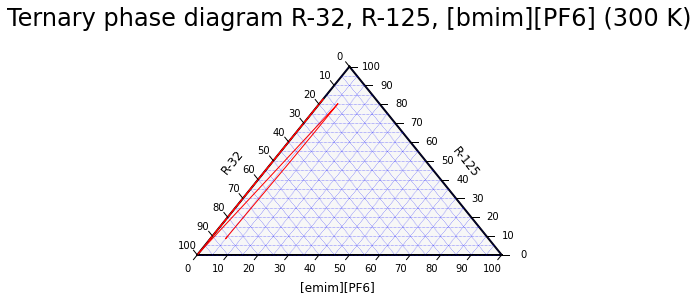

In [9]:
import ternary

scale = 100
figure, tax = ternary.figure(scale=scale)

# Draw Boundary and Gridlines
tax.boundary(linewidth=2.0)
tax.gridlines(color="blue", multiple=5)

# Set Axis labels and Title
fontsize = 12
offset = 0.14
tax.set_title("Ternary phase diagram R-32, R-125, [bmim][PF6] (300 K)\n", fontsize=24)
tax.left_axis_label("R-32", fontsize=fontsize, offset=offset)
tax.right_axis_label("R-125", fontsize=fontsize, offset=offset)
tax.bottom_axis_label("[emim][PF6]", fontsize=fontsize, offset=offset)

# color_options = ['red','blue','green','black','orange','purple','teal','yellow','pink']

for i in range(len(P)):
#     color = color_options[i]
    if P[i]<=1400000:
        i = i + 1

        tax.plot(points_x[9*i-9:9*i], linewidth=1., color='red', linestyle="-")
    elif P[i]==1500000:
        i = i + 1

        tax.plot(points_x[9*i-8:9*i], linewidth=1., color='red', linestyle="-")
    else:
        i = i + 1

        tax.plot(points_x[9*i-6:9*i], linewidth=1., color='red', linestyle="-")

for i in range(len(P)):
#     color = color_options[i]
    if P[i]<=1400000:
        i = i + 1

        tax.plot(points_y[9*i-9:9*i], linewidth=1., color='red', linestyle="-")
    elif P[i]==1500000:
        i = i + 1

        tax.plot(points_y[9*i-8:9*i], linewidth=1., color='red', linestyle="-")
    else:
        i = i + 1

        tax.plot(points_y[9*i-6:9*i], linewidth=1., color='red', linestyle="-")
        
tax.ticks(axis='lbr', multiple=10, linewidth=1, offset=0.025)
tax.get_axes().axis('off')
tax.clear_matplotlib_ticks()
tax.show()

In [10]:
print("IL x",IL_x)
print("IL y",IL_y)
print("32 x",R32_x)
print("32 y",R32_y)
print("125 x",R125_x)
print("125 y",R125_y)

IL x [[0.         6.07327058 6.05431586 5.98738939 5.88381694 5.74554367
  5.32680074 5.00001364 5.00001736]]
IL y [[0.e+00 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06]]
32 x [[ 0.         13.62077372 18.21402936 27.49799433 36.92109679 46.48386025
  67.93066727 86.44998365 85.49997884]]
32 y [[ 0.         17.18134973 22.72739646 33.57401475 44.10365767 54.31475669
  75.58071697 92.44371038 91.59307052]]
125 x [[ 0.         80.30595571 75.73165478 66.51461628 57.19508627 47.77059607
  26.74253198  8.55000271  9.5000038 ]]
125 y [[ 0.         82.81865027 77.27260354 66.42598525 55.89634233 45.68524331
  24.41928303  7.55628962  8.40692948]]


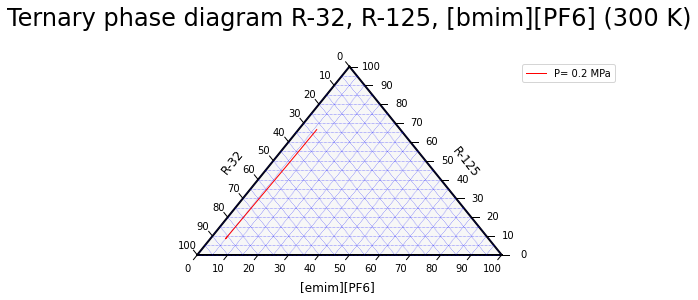

In [11]:
import ternary

scale = 100
figure, tax = ternary.figure(scale=scale)

# Draw Boundary and Gridlines
tax.boundary(linewidth=2.0)
tax.gridlines(color="blue", multiple=5)

# Set Axis labels and Title
fontsize = 12
offset = 0.14
tax.set_title("Ternary phase diagram R-32, R-125, [bmim][PF6] (300 K)\n", fontsize=24)
tax.left_axis_label("R-32", fontsize=fontsize, offset=offset)
tax.right_axis_label("R-125", fontsize=fontsize, offset=offset)
tax.bottom_axis_label("[emim][PF6]", fontsize=fontsize, offset=offset)

tax.plot(points_x[3:9], linewidth=1., color='red', linestyle="-", label='P= 0.2 MPa')
# tax.plot(points_x[10:18], linewidth=1., color='blue', linestyle="-", label='P= 0.3 MPa')
# tax.plot(points_x[20:26], linewidth=1., color='green', linestyle="-", label='P= 0.4 MPa')
# tax.plot(points_x[29:36], linewidth=1., color='red', linestyle="-", label='P= 0.5 MPa')
# tax.plot(points_x[37:43], linewidth=1., color='blue', linestyle="-", label='P= 0.6 MPa')
# tax.plot(points_x[47:49], linewidth=1., color='green', linestyle="-", label='P= 0.7 MPa')

tax.ticks(axis='lbr', multiple=10, linewidth=1, offset=0.025)
tax.legend(bbox_to_anchor=(1,1))
tax.get_axes().axis('off')
tax.clear_matplotlib_ticks()
tax.show()